## Importing Required Packages 

In [1]:
import sqlite3
import pdfplumber
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')
import re
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

## Data Collection

In [2]:
#connecting to db 
conn = sqlite3.connect('trace-data.db')

cursor = conn.cursor()

In [5]:
# cursor.execute("""drop table courses""")
# cursor.execute("""drop table sections""")
# cursor.execute("""drop table instructors""")
# cursor.execute("""drop table departments""")
# cursor.execute("""drop table colleges""")
# cursor.execute("""drop table qgroups""")
# cursor.execute("""drop table questions""")
# cursor.execute("""drop table campuses""")
# cursor.execute("""drop table evalfacts""")
# cursor.execute("""drop table comments""")

### Constant Tables
Creating a schema and inputting values for tables that always have constant values

In [6]:

#creating a table for question groups
cursor.execute('''create table if not exists
              qgroups(qgid integer primary key,
              qgroup varchar(255))''')

group = 'Questions to Assess Students’ Online Experience rating'
cursor.execute("""INSERT INTO qgroups VALUES(?,?)""",(1,group))

group = 'Course Related Questions rating'
cursor.execute("""INSERT INTO qgroups VALUES(?,?)""",(2, group))

group = 'Learning Related Questions rating'
cursor.execute("""INSERT INTO qgroups VALUES(?,?)""",(3, group))

group = 'Instructor Related Questions rating'
cursor.execute("""INSERT INTO qgroups VALUES(?,?)""",(4, group))

group = 'Instructor Effectiveness rating'
cursor.execute("""INSERT INTO qgroups VALUES(?,?)""",(5, group))

group = 'Instructor Related reviews'
cursor.execute("""INSERT INTO qgroups VALUES(?,?)""",(6, group))

group = 'Questions to Assess Students’ Online Experience reviews'
cursor.execute("""INSERT INTO qgroups VALUES(?,?)""",(7, group))

group = 'Student Self-Assessment of their Effort to Achieve Course Outcomes'
cursor.execute("""INSERT INTO qgroups VALUES(?,?)""",(8, group))

#creating a table for colleges
cursor.execute('''create table if not exists
                 colleges(ccid integer primary key,
                 name varchar(255))''')

name = 'College of Computer Info Sciences'
cursor.execute("""INSERT INTO colleges VALUES(NULL,?)""",[name])

name = 'Bouvé College of Health Sciences'
cursor.execute("""INSERT INTO colleges VALUES(NULL,?)""",[name])

name = 'D’Amore-McKim School of Business'
cursor.execute("""INSERT INTO colleges VALUES(NULL,?)""",[name])

name = 'College of Science'
cursor.execute("""INSERT INTO colleges VALUES(NULL,?)""",[name])

name = 'Office of Provost'
cursor.execute("""INSERT INTO colleges VALUES(NULL,?)""",[name])

name = 'College of Social Sciences and Humanities'
cursor.execute("""INSERT INTO colleges VALUES(NULL,?)""",[name])

name = 'College of Engineering'
cursor.execute("""INSERT INTO colleges VALUES(NULL,?)""",[name])

name = 'College of Arts, Media and Design'
cursor.execute("""INSERT INTO colleges VALUES(NULL,?)""",[name])

#creating a table for departments
cursor.execute('''create table if not exists
                 departments(did integer primary key,
                 name varchar(50),
                 ccid integer)''')

name = 'CS'
ccid = 1

cursor.execute("""INSERT INTO departments VALUES(?,?,?)""",(1, name,ccid))

name = 'DS'
cursor.execute("""INSERT INTO departments VALUES(?,?,?)""",(2, name,ccid))

name = 'IS'
cursor.execute("""INSERT INTO departments VALUES(?,?,?)""",(3, name,ccid))

name = 'CY'
cursor.execute("""INSERT INTO departments VALUES(?,?,?)""",(4, name,ccid))

#creating a table for campuses
cursor.execute('''create table if not exists
                 campuses(cpid integer primary key,
                 name varchar(50),
                 city varchar(100),
                 country varchar(50))''')

name = 'Northeastern University-Boston'
city = 'Boston'
country = 'United States'
cursor.execute("""INSERT INTO campuses VALUES(?,?,?,?)""",(1, name,city,country))

name = 'Northeastern University-Charlotte'
city = 'Charlotte'
country = 'United States'
cursor.execute("""INSERT INTO campuses VALUES(?,?,?,?)""",(2, name,city,country))

name = 'New College of the Humanities'
city = 'London'
country = 'United Kingdom'
cursor.execute("""INSERT INTO campuses VALUES(?,?,?,?)""",(3, name,city,country))

name = 'Northeastern University-San Francisco'
city = 'San Francisco'
country = 'United States'
cursor.execute("""INSERT INTO campuses VALUES(?,?,?,?)""",(4, name,city,country))

name = 'Northeastern University–Seattle'
city = 'Seattle'
country = 'United States'
cursor.execute("""INSERT INTO campuses VALUES(?,?,?,?)""",(5, name,city,country))

name = 'Northeastern University–Silicon Valley'
city = 'Silicon Valley'
country = 'United States'
cursor.execute("""INSERT INTO campuses VALUES(?,?,?,?)""",(6, name,city,country))

name = 'Northeastern University–Toronto'
city = 'Toronto'
country = 'Canada'
cursor.execute("""INSERT INTO campuses VALUES(?,?,?,?)""",(7, name,city,country))

name = 'Northeastern University–Vancouver'
city = 'Vancouver'
country = 'United States'
cursor.execute("""INSERT INTO campuses VALUES(?,?,?,?)""",(8, name,city,country))

name = 'Roux Institute at Northeastern University'
city = 'Portland,Maine'
country = 'United States'
cursor.execute("""INSERT INTO campuses VALUES(?,?,?,?)""",(9, name,city,country))

#creating a table for questions
cursor.execute(''' create table if not exists
                questions(qid integer not null primary key,
                qtext text,
                qtype varchar(255),
                qgroup integer,
                foreign key(qgroup) references qgroups(qgroup))''')

qgroup = 1
qtype = 'scale'
qtext = 'Online course materials were organized to help me navigate through the course week by week.'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(1,qtext,qtype,qgroup))

qtext = 'Online interactions with my instructor created a sense of connection in the virtual classroom.'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(2,qtext,qtype,qgroup))

qtext = 'Online course interactions created a sense of community and connection to my classmates.'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(3,qtext,qtype,qgroup))

qtext = 'I had the necessary computer skills and technology to successfully complete the course.'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(4,qtext,qtype,qgroup))

qgroup = 2
qtype = 'scale'
qtext = 'The syllabus was accurate and helpful in delineating expectations and course outcomes.'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(5,qtext,qtype,qgroup))
qtext = 'Required and additional course materials were helpful in achieving course outcomes.'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(6,qtext,qtype,qgroup))

qgroup = 3
qtype = 'scale'
qtext = 'In-class sessions were helpful for learning.'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(7,qtext,qtype,qgroup))
qtext = 'Out-of-class assignments and/or fieldwork were helpful for learning.'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(8,qtext,qtype,qgroup))
qtext = 'This course was intellectually challenging.'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(9,qtext,qtype,qgroup))
qtext = 'I learned a lot in this course.'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(10,qtext,qtype,qgroup))

qgroup = 4
qtype = 'scale'
qtext = 'The instructor came to class prepared to teach.' 
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(11,qtext,qtype,qgroup))
qtext = 'The instructor used class time effectively. '
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(12,qtext,qtype,qgroup))
qtext = 'The instructor clearly communicated ideas and information.'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(13,qtext,qtype,qgroup))
qtext = 'The instructor provided sufficient feedback. '
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(14,qtext,qtype,qgroup))
qtext = 'The instructor fairly evaluated my performance.'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(15,qtext,qtype,qgroup))
qtext = 'The instructor was available to assist students outside of class.'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(16,qtext,qtype,qgroup))
qtext = 'The instructor facilitated a respectful and inclusive learning environment.'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(17,qtext,qtype,qgroup))
qtext = 'The instructor displayed enthusiasm for the course.'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(18,qtext,qtype,qgroup))

qgroup = 5
qtype = 'scale'
qtext = 'What is your overall rating of this instructors teaching effectiveness?'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(19,qtext,qtype,qgroup))

qgroup = 6
qtype = 'text'
qtext = 'Q: What were the strengths of this course and/or this instructor?'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(20,qtext,qtype,qgroup))
qtext = 'Q: What could the instructor do to make this course better?'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(21,qtext,qtype,qgroup))
qtext = 'Q: Please expand on the instructor’s strengths and/or areas for improvement in facilitating inclusive learning.'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(22,qtext,qtype,qgroup))

qgroup = 7
qtype = 'text'
qtext = 'Q: Please comment on your experience of the online course environment in the open-ended text box.'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(23,qtext,qtype,qgroup))

qgroup = 8
qtype = 'text'
qtext = 'Q: What I could have done to make this course better for myself.'
cursor.execute("""INSERT INTO questions VALUES(?,?,?,?)""",(24,qtext,qtype,qgroup))

#Since the data does not have the original CRN number, It has been inititialized with a temporary value
crn = 10000

### Non Constant Tables
Creating schema and inputting values in tables that do not have constant values

In [8]:
path = #Path to projectdata
for semester in ['spring2021','summer2021']:
    
    #accessing path to the folder which consists of all of the TRACE review files
    if semester == 'spring2021':
        loc = path + '/spring2021/'
    elif semester == 'summer2021':
        loc = path + '/summer 2021/'

    onlyfiles = [f for f in listdir(loc) if isfile(join(loc, f))]

    files = [loc + s for s in onlyfiles]

    for file in files:
        #print(file)
        #Iterating through each pdf
        with pdfplumber.open(file) as pdf:
            totalpages = len(pdf.pages)
            text = ''
            #Iterating through each page in the pdf
            for i in range(0 ,totalpages):
                pageobj = pdf.pages[i]
                if pageobj.extract_text()!= None:
                    text = text + pageobj.extract_text()

        #creating courses table
        cursor.execute('''create table if not exists
                      courses(cid integer not null primary key,
                      area varchar(255),
                      number integer,
                      name varchar(255))''')

        #collecting the courseid
        start = '\nCourse\tID:\t'
        end = '\nObjectives:\n'
        cid = int(text[text.find(start)+len(start):text.rfind(end)].replace('\t',' '))

        #collecting name
        name = text.partition('\n')[0].replace('\t', ' ')

        #collecting course number
        start = '\nCatalog\t&\tSection:\t'
        end = ' Declines:\t'
        number = int(text[text.find(start)+len(start):text.rfind(end)].replace('\t',''))

        #temporarily assigning the area of courses to boston campus, because TRACE does not provide information
        #of campus location
        area = 1

        cursor.execute("select * from courses")

        result = cursor.fetchall()

        if len(result)==0:
            cursor.execute("""INSERT INTO courses VALUES(?,?, ?, ?)""",(cid,area,number, name))
        else:
            cursor.execute("select cid from courses")
            result = cursor.fetchall()

            present = 0
            for i in range(0,len(result)):

                if cid == result[i][0]:
                    present = 1
                    break
                else:
                    continue

            if present !=1:
                cursor.execute("""INSERT INTO courses VALUES(?,?, ?, ?)""",(cid,area,number, name))

        #creating a table for instructors
        cursor.execute('''create table if not exists
                     instructors(iid integer not null primary key,
                     rank varchar(50),
                     lname varchar(255),
                     fname varchar(255),
                     ccid integer,
                     did integer,
                     cpid integer,
                     foreign key(cpid) references campuses(cpid),
                     foreign key(did) references departments(did),
                     foreign key(ccid) references colleges(ccid))''')

        #temporarily assigning the rank of professor as 'Not Available' since it is not available in the TRACE data
        rank = "Not Available"

        #collecting instructor name
        start = '\nInstructor:'
        end ='Enrollment:'
        s = text

        fullname = s[s.find(start)+len(start):s.rfind(end)].replace('\t',' ')
        lname = fullname.partition(',')[0].replace('\t', ' ')[1:]
        fname = fullname.partition(',')[2].replace('\t', ' ')[1:-1]
        name = fname + lname

        #collecting instructor department
        start = 'Subject:'
        end = 'Responses Incl Declines:'
        s = text

        department = s[s.find(start)+len(start):(s.find(start)+len(start)+3)].replace('\t',' ')[1:]

        if department == 'CS':
            did = 1
        elif department == 'DS':
            did = 2
        elif department == 'IS':
            did = 3
        else:
            did = 4

        #Assigning campus id as 1(boston) for all courses
        cpid = 1

        cursor.execute("select * from instructors")

        result = cursor.fetchall()

        if len(result)==0:
            cursor.execute("""INSERT INTO instructors VALUES(NULL,?,?,?,?,?,?)""",(rank,lname,fname,ccid,did,cpid))
        else:
            cursor.execute("select fname || lname from instructors")
            result = cursor.fetchall()

            present = 0
            for i in range(0,len(result)):
                if name == result[i][0]:
                    present = 1
                    break
                else:
                    continue

            if present !=1:
                cursor.execute("""INSERT INTO instructors VALUES(NULL,?,?,?,?,?,?)""",(rank,lname,fname,ccid,did,cpid))

        #creating a table to store evaluation facts
        cursor.execute('''create table if not exists
                evalfacts(efid integer not null primary key autoincrement,
                crn integer,
                qid integer,
                qgid integer,
                instructor varchar(255),
                term varchar(50),
                num integer,
                rrate float,
                course_mean float,
                dept_mean float,
                univ_mean float,
                course_median float,
                dept_median float,
                univ_median float,
                foreign key(crn) references sections(crn),
                foreign key(qid) references questions(qid),
                foreign key(qgid) references qgroups(qgid))''')

        qgid = 1
        qid = 1

        #collecting instructor info
        start = '\nInstructor:'
        end ='Enrollment:'
        s = text

        instructor = s[s.find(start)+len(start):s.rfind(end)].replace('\t',' ')

        import re
        course = text.partition('\n')[0].replace('\t', ' ')
        term = course[course.find("(")+1:course.find(")")]

        #list of partition strings used to split and access the data of interest
        rating_sys = ['\nOnline\tcourse\tmaterials\twere\torganized\tto\thelp\tme\tnavigate(.*)\nthrough\tthe\tcourse\tweek\tby\tweek',
        '\nOnline\tinteractions\twith\tmy\tinstructor\tcreated\ta\tsense\tof(.*)\nconnection\tin\tthe\tvirtual\tclassroom',
        '\nOnline\tcourse\tinteractions\tcreated\ta\tsense\tof\tcommunity\tand(.*)\nconnection\tto\tmy\tclassmates',
        '\nI\thad\tthe\tnecessary\tcomputer\tskills\tand\ttechnology\tto(.*)\nsuccessfully\tcomplete\tthe\tcourse.',
        '\nThe\tsyllabus\twas\taccurate\tand\thelpful\tin\tdelineating(.*)\nexpectations\tand\tcourse\toutcomes.',
        '\nRequired\tand\tadditional\tcourse\tmaterials\twere\thelpful\tin(.*)\nachieving\tcourse\toutcomes.',
        '\nIn-class\tsessions\twere\thelpful\tfor\tlearning.(.*)\nOut-of-class\tassignments\tand/or\tfieldwork\twere', 
        '\nOut-of-class\tassignments\tand/or\tfieldwork\twere(.*)\nhelpful\tfor\tlearning.\nThis\tcourse\twas\tintellectually\tchallenging.',
        '\nhelpful\tfor\tlearning.\nThis\tcourse\twas\tintellectually\tchallenging.(.*)\nI\tlearned\ta\tlot\tin\tthis\tcourse.',
        '\nI\tlearned\ta\tlot\tin\tthis\tcourse.(.*)\nNote:\t5:Strongly\tAgree;\t4:Agree;\t3:Neutral;\t2:Disagree;\t1:Strongly\tDisagree;',
        '\nThe\tinstructor\tcame\tto\tclass\tprepared\tto\tteach.(.*)\nThe\tinstructor\tused\tclass\ttime\teffectively.',
        '\nThe\tinstructor\tused\tclass\ttime\teffectively.(.*)\nThe\tinstructor\tclearly\tcommunicated\tideas\tand',
        '\nThe\tinstructor\tclearly\tcommunicated\tideas\tand(.*)\ninformation.',
        '\nThe\tinstructor\tprovided\tsufficient\tfeedback.(.*)\nThe\tinstructor\tfairly\tevaluated\tmy\tperformance.',
        '\nThe\tinstructor\tfairly\tevaluated\tmy\tperformance.(.*)\nThe\tinstructor\twas\tavailable\tto\tassist\tstudents',
        '\nThe\tinstructor\twas\tavailable\tto\tassist\tstudents(.*)\noutside\tof\tclass.',
        '\nThe\tinstructor\tfacilitated\ta\trespectful\tand\tinclusive(.*)\nlearning\tenvironment.',
        '\nThe\tinstructor\tdisplayed\tenthusiasm\tfor\tthe\tcourse.(.*)\nNote:\t5:Strongly\tAgree;\t4:Agree;\t3:Neutral;\t2:Disagree;\t1:Strongly\tDisagree;',
        "\nWhat\tis\tyour\toverall\trating\tof\tthis\tinstructor's(.*)\nteaching\teffectiveness?"]

        for i in rating_sys:
            result = re.search(i, text)

            if qid in [5,7,11,19]:
                qgid+=1
            num = [float(s) for s in re.findall(r"[-+]?\d*\.\d+|\d+", result.group(1).replace("%", ""))][0]
            rrate = [float(s) for s in re.findall(r"[-+]?\d*\.\d+|\d+", result.group(1).replace("%", ""))][1]
            course_mean = [float(s) for s in re.findall(r"[-+]?\d*\.\d+|\d+", result.group(1).replace("%", ""))][2]
            dept_mean = [float(s) for s in re.findall(r"[-+]?\d*\.\d+|\d+", result.group(1).replace("%", ""))][3]
            univ_mean = [float(s) for s in re.findall(r"[-+]?\d*\.\d+|\d+", result.group(1).replace("%", ""))][4]
            course_median = [float(s) for s in re.findall(r"[-+]?\d*\.\d+|\d+", result.group(1).replace("%", ""))][5]
            dept_median = [float(s) for s in re.findall(r"[-+]?\d*\.\d+|\d+", result.group(1).replace("%", ""))][6]
            univ_median = [float(s) for s in re.findall(r"[-+]?\d*\.\d+|\d+", result.group(1).replace("%", ""))][7]

            cursor.execute("""INSERT INTO evalfacts VALUES(NULL,?,?,?,?,?,?,?,?,?,?,?,?,?)""",(crn,qid,qgid,instructor,term,num,rrate,
                                                                               course_mean,dept_mean,univ_mean,course_median,
                                                                               dept_median,univ_median))     
            qid = qid+1

        #creating a table for sections
        cursor.execute('''create table if not exists
                 sections(crn integer not null primary key,
                 term varchar(50),
                 year integer,
                 iid integer,
                 cp_id integer,
                 cid integer,
                 foreign key(cid) references courses(cid),
                 foreign key(iid) references instructors(iid),
                 foreign key(cp_id) references campuses(cp_id))''')

        #collecting term data
        term = s[s.find("(")+len("("):s.find(")")].replace('\t',' ')[:-5]

        #collecting year data
        year = s[s.find("(")+len("("):s.find(")")].replace('\t',' ')[-4:]

        iid = cursor.lastrowid

        if iid == cid:

            iid = cursor.execute("select iid from instructors where fname || lname = '" + name + "'").fetchone()[0]

        cursor.execute('''insert into sections values (?,?,?,?,?,?)''',(crn,term,year,iid,cpid,cid))

        #creating a table to collect the review comments
        cursor.execute(''' create table if not exists
                   comments(cmid integer not null primary key,
                   crn integer,
                   qid integer,
                   response text,
                   foreign key(crn) references sections(crn),
                   foreign key(qid) references questions(qid))''')

        import re

        def insertcomments(crn,qid,start,end,text):

            if end == None:
                s = text[text.find(start)+len(start):].replace('\t',' ')
            else:
                s = text[text.find(start)+len(start):text.rfind(end)].replace('\t',' ')

            number = re.findall(r'\d+', s)
            indexes = []
            for i in number:
                indexes.append("{}{} ".format('\n', i))

                if s.find(indexes[-1]) == -1:
                    indexes.pop()

            for i in range(0,len(indexes)):

                if i+1 == len(indexes):

                    start = indexes[i]
                    end = "end"

                    response = s[s.find(start)+len(start):].replace('\t',' ')

                    cursor.execute("""INSERT INTO comments VALUES(NULL,?,?,?)""",(crn,qid,response))

                else:  
                    start = indexes[i]
                    end = indexes[i+1]

                    response = s[s.find(start)+len(start):s.rfind(end)].replace('\t',' ')

                    cursor.execute("""INSERT INTO comments VALUES(NULL,?,?,?)""",(crn,qid,response))

        start = 'Q:\tWhat\twere\tthe\tstrengths\tof\tthis\tcourse\tand/or\tthis\tinstructor?'
        if text.find(start) != -1:
            insertcomments(crn,20,'Q:\tWhat\twere\tthe\tstrengths\tof\tthis\tcourse\tand/or\tthis\tinstructor?','\nQ:\tWhat\tcould\tthe\tinstructor\tdo\tto\tmake\tthis\tcourse\tbetter?',text)

        start = '\nQ:\tWhat\tcould\tthe\tinstructor\tdo\tto\tmake\tthis\tcourse\tbetter?'
        if text.find(start) != -1:
            insertcomments(crn,21,'\nQ:\tWhat\tcould\tthe\tinstructor\tdo\tto\tmake\tthis\tcourse\tbetter?','\nQ:\tPlease\texpand\ton\tthe\tinstructor’s\tstrengths\tand/or\tareas\tfor\timprovement\tin\tfacilitating\tinclusive\tlearning.',text)

        start = '\nQ:\tPlease\texpand\ton\tthe\tinstructor’s\tstrengths\tand/or\tareas\tfor\timprovement\tin\tfacilitating\tinclusive\tlearning.'
        if text.find(start) != -1:
            insertcomments(crn,22,'\nQ:\tPlease\texpand\ton\tthe\tinstructor’s\tstrengths\tand/or\tareas\tfor\timprovement\tin\tfacilitating\tinclusive\tlearning.',
                          '\nQ:\tPlease\tcomment\ton\tyour\texperience\tof\tthe\tonline\tcourse\tenvironment\tin\tthe\topen-ended\ttext\tbox.',text)

        start = '\nQ:\tPlease\tcomment\ton\tyour\texperience\tof\tthe\tonline\tcourse\tenvironment\tin\tthe\topen-ended\ttext\tbox.'
        if text.find(start) != -1:

            end = 'Questions\tto\tAssess\tStudents’\tOnline\tExperience'

            insertcomments(crn,23,start,end,text)

        start = '\nQ:\tWhat\tI\tcould\thave\tdone\tto\tmake\tthis\tcourse\tbetter\tfor\tmyself.'
        if text.find(start) != -1:
            insertcomments(crn,24,'\nQ:\tWhat\tI\tcould\thave\tdone\tto\tmake\tthis\tcourse\tbetter\tfor\tmyself.',
                           None,text)

        crn = crn + 1

        conn.commit()


## Converting tables into dataframes

In [10]:
cursor.execute("""select * from courses""")
courses = cursor.fetchall()

courses = pd.DataFrame(courses, columns = ['cid','area','number','name'])

cursor.execute("""select * from sections""")
sections = cursor.fetchall()

sections = pd.DataFrame(sections,columns = ['crn','term','year','cid','iid','cpid'])

cursor.execute("""select * from instructors""")
instructors = cursor.fetchall()

instructors = pd.DataFrame(instructors,columns = ['iid','rank','lname','fname','college','dept','cpid'])

cursor.execute("""select * from departments""")
departments = cursor.fetchall()

departments = pd.DataFrame(departments,columns = ['did','name','ccid'])

cursor.execute("""select * from colleges""")
colleges = cursor.fetchall()

colleges = pd.DataFrame(colleges,columns = ['ccid','name'])

cursor.execute("""select * from campuses""")
campuses = cursor.fetchall()

campuses = pd.DataFrame(campuses,columns = ['cpid','name','city','country'])

cursor.execute("""select * from comments""")
comments = cursor.fetchall()

comments = pd.DataFrame(comments,columns = ['cmid','crn','qid','response'])

cursor.execute("""select * from evalfacts""")
rating = cursor.fetchall()

rating = pd.DataFrame(rating, columns =['efid', 'crn', 'qid','qgid','instructor','term','num','rrate','course_mean',
                                        'dept_mean','univ_mean','course_median','dept_median','univ_median'])

cursor.execute("""select * from questions""")
questions = cursor.fetchall()

questions = pd.DataFrame(questions,columns = ['qid','qtext','qtype','qgroup'])

cursor.execute("""select * from qgroups""")
qgroups = cursor.fetchall()

qgroups = pd.DataFrame(qgroups,columns = ['qgid','qgroup'])

## Data Cleaning

In [11]:
data = comments.merge(questions[["qid", "qtext"]])

#converting responses into lowercase
data['response'] = data['response'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#Removing punctuations
data['response'] = data['response'].str.replace('[^\w\s]','')

#Removing na value rows
data = data[~data['response'].isin(['', 'N/A','None','n/a','none', 'na'])]

stop = stopwords.words('english')

# removing stopwords
data['response']  = data['response'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# Removing non-alpha characters
data['response'] = data.response.str.replace('[^a-zA-Z]', ' ')

#pos tagging 
def pos_tagging(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def wordnet_lemmatize(sentence):
    #tokenize the sentence and find the POS tag for each token
    pos_tag = nltk.pos_tag(nltk.word_tokenize(sentence))
    tagged_tuple = map(lambda x: (x[0], pos_tagging(x[1])), pos_tag)
    lemmatized_sentence = []
    for word, tag in tagged_tuple:
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

# Lemmatizing
data['response'] = data['response'].apply(lambda x: wordnet_lemmatize(x))

In [12]:
#Subsetting the data to only collect the question of interest which focuses only on the instructors performance and not the coursework
imp_q = data[data.values  == 'Q: Please expand on the instructor’s strengths and/or areas for improvement in facilitating inclusive learning.']

## Data Labelling

In [13]:
sid = SentimentIntensityAnalyzer()

polarity = []

for sentence in imp_q.response:
    ss = sid.polarity_scores(sentence) 
    if ss['compound'] >= 0.25 :   
        polarity.append("Positive")
    elif ss['compound'] < 0.0:
        polarity.append("Negative")
    else:
        polarity.append("Neutral")

imp_q["sentiment"] = polarity
imp_q.head()

<ipython-input-13-3fd597ad6216>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imp_q["sentiment"] = polarity


,cmid,crn,qid,response,qtext,sentiment
7976,5,10000,22,great listener flexible adjust class session s...,Q: Please expand on the instructor’s strengths...,Positive
7978,7,10000,22,sami open honest journey specifically identity...,Q: Please expand on the instructor’s strengths...,Positive
7979,47,10001,22,explain thing well class participation student...,Q: Please expand on the instructor’s strengths...,Positive
7980,48,10001,22,prior question good explain course material le...,Q: Please expand on the instructor’s strengths...,Positive
7982,50,10001,22,example use lecture video always apply quizzes...,Q: Please expand on the instructor’s strengths...,Positive


<AxesSubplot:ylabel='sentiment'>

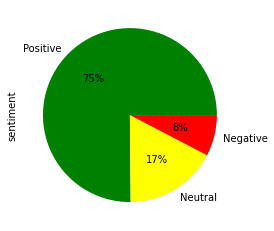

In [14]:
imp_q.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["green", "yellow", "red"])

From the above pie chart we can understand that most of the reviews provided to the instructors were postively inclined

## Data Modelling

In [15]:
reviews = np.array(imp_q['response'])
sentiments = np.array(imp_q['sentiment'])

from sklearn.model_selection import train_test_split
# build train and test datasets
train_reviews, test_reviews, train_sentiments, test_sentiments =\
    train_test_split(reviews, sentiments , test_size=0.20,  random_state=101)

# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2), sublinear_tf=True)
tv_train_features = tv.fit_transform(train_reviews)
tv_test_features = tv.transform(test_reviews)

In [16]:
#Oversampling the data to handle class imbalance
sm = SMOTE(random_state=777,sampling_strategy={'Positive': 1346, 'Negative': 1346, 'Neutral': 1346})
sm_xtrain_tfidf, sm_train_y = sm.fit_resample(tv_train_features, train_sentiments)

## Logistic Regression

In [17]:
lr = LogisticRegression(penalty='l2',multi_class='multinomial',solver = 'lbfgs', max_iter=100, C=1)


lr.fit(sm_xtrain_tfidf, sm_train_y)

# predict using model
predicted_labels = lr.predict(tv_test_features) 
print('Accuracy on Test Data:  {:2.2%} '.format(metrics.accuracy_score(test_sentiments, predicted_labels)))
print('Precision on Test Data: {:2.2%} '.format(metrics.precision_score(test_sentiments, predicted_labels, average='weighted')))
print('Recall on Test Data:    {:2.2%} '.format(metrics.recall_score(test_sentiments, predicted_labels, average='weighted')))
print('F1 Score on Test Data:  {:2.2%} '.format(metrics.f1_score(test_sentiments, predicted_labels, average='weighted')))

print(confusion_matrix(test_sentiments, predicted_labels))

Accuracy on Test Data:  80.90% 
Precision on Test Data: 79.43% 
Recall on Test Data:    80.90% 
F1 Score on Test Data:  78.90% 
[[ 10   5  28]
 [  2  45  30]
 [  3  17 305]]


## Decision Tree Classifier

In [18]:
from sklearn.tree import DecisionTreeClassifier
dct = DecisionTreeClassifier(criterion='entropy', random_state=1,max_depth=100)

dct.fit(sm_xtrain_tfidf, sm_train_y)

predicted_labels = dct.predict(tv_test_features)

print('Accuracy:  {:2.2%} '.format(metrics.accuracy_score(test_sentiments, predicted_labels)))
print('Precision: {:2.2%} '.format(metrics.precision_score(test_sentiments, predicted_labels, average='weighted')))
print('Recall:    {:2.2%} '.format(metrics.recall_score(test_sentiments, predicted_labels, average='weighted')))
print('F1 Score:  {:2.2%} '.format(metrics.f1_score(test_sentiments, predicted_labels, average='weighted')))

print(confusion_matrix(test_sentiments, predicted_labels))

Accuracy:  79.33% 
Precision: 78.85% 
Recall:    79.33% 
F1 Score:  78.77% 
[[ 12  10  21]
 [  0  58  19]
 [ 15  27 283]]


## Do ratings do a good job at representing students true opinions

In [19]:
#Identifying the majority sentiment of all of the reviews left for that particular course
majority_review = pd.DataFrame(imp_q.groupby(['crn'])['sentiment'].agg(pd.Series.mode))
majority_review.reset_index(level=0, inplace=True)
majority_review.sentiment = majority_review.sentiment.astype(str)
majority_review["sentiment"].replace({"['Negative' 'Neutral']": "Negative", "['Negative' 'Positive']":"Negative",
                                     "['Negative' 'Neutral' 'Positive']": "Negative"}, inplace=True)

instructor_effectiveness = rating[rating.qgid == 5]
majority_review_rating = instructor_effectiveness.merge(majority_review, on = ['crn'], how='left')

#average course_mean of reviews that had positive sentiments
print("Average course mean rating of the reviews that had positive sentiments", 
      round(majority_review_rating[majority_review_rating.sentiment=='Positive'].course_mean.mean(),2))

#average course_mean of reviews that had positive sentiments
print("Average course mean rating of the reviews that had negative sentiments",
      round(majority_review_rating[majority_review_rating.sentiment=='Negative'].course_mean.mean(),2))

Average course mean rating of the reviews that had positive sentiments 4.44
Average course mean rating of the reviews that had negative sentiments 3.91


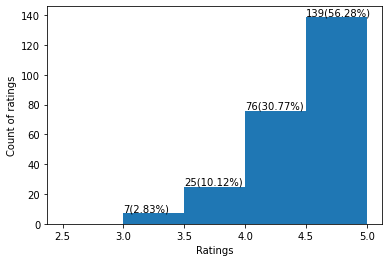

In [20]:
#Plot to show the distribution of ratings for professors with positive sentiments
hist = list(majority_review_rating[majority_review_rating.sentiment=='Positive'].course_mean)

import numpy as np
import matplotlib.pyplot as plt

bins_list = [2.5,3,3.5,4,4.5,5]

density, bins, _ = plt.hist(hist, density=False,bins = bins_list)

count, _ = np.histogram(hist, bins)

for x,y,num in zip(bins, density, count):
    if num != 0:
        plt.text(x, y+1, str(num) + '(' + str(round((num/len(hist))*100,2))  + '%'+ ')', fontsize=10, rotation=0) 

plt.ylabel('Count of ratings')
plt.xlabel('Ratings');

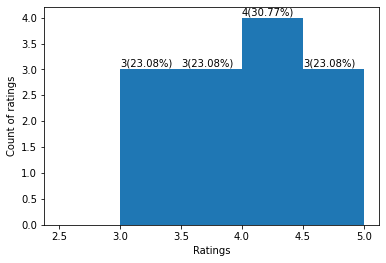

In [21]:
#Plot to show the distributions of ratings for professors with negative sentiments
hist_neg = list(majority_review_rating[majority_review_rating.sentiment=='Negative'].course_mean)

import numpy as np
import matplotlib.pyplot as plt

bins_list = [2.5,3,3.5,4,4.5,5]

density, bins, _ = plt.hist(hist_neg, density=False,bins = bins_list)

count, _ = np.histogram(hist_neg, bins)

for x,y,num in zip(bins, density, count):
    if num != 0:
        plt.text(x, y+ 0.05, str(num) + '(' + str(round((num/len(hist_neg))*100,2))  + '%'+ ')', fontsize=10, rotation=0) 

plt.ylabel('Count of ratings')
plt.xlabel('Ratings');

## Identifying University Violation

In [22]:
#List should be further updated to ensure more coverage of violations
violation = ['inappropriate behavior','offensive','sexual advance', 'sexual abuse', 'sexual pressure','suggestive comments',
             'unprofessional behaviour','sexual jokes','sexist','inappropriate touching','unsolicited touching',
            'unwanted touching','inappropriate contact','racism','racist','racial discrimination','anti-semitism',
            'racial discrimination','late grading','no grading']

def violation_word_checker(comment):  
    if any(word in violation for word in comment.lower().split()):
        return 1
    else:
        return 0 

violation_marker = []
for i in data['response']:
    violation_marker.append(violation_word_checker(i))
    
data['violation'] = violation_marker